In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from collections import Counter
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, mixed_precision, regularizers
import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import pandas as pd
from tensorflow.keras.regularizers import l2

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)  
#     except RuntimeError as e:
#         print(e)

In [36]:
mixed_precision.set_global_policy("mixed_float16")

In [37]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15
DATA_DIR = "training/dataPrep" 

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/val",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DATA_DIR}/test",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 18906 files belonging to 19 classes.
Found 4054 files belonging to 19 classes.
Found 4064 files belonging to 19 classes.


In [39]:
N_CLASSES = len(train_ds.class_names)
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)
print(f'Number of Classes: {N_CLASSES}')

['aloe__healthy', 'aloe__leaf_spot', 'aloe__rust', 'aloe__sunburn', 'aloe_anthracnose', 'moneyplant__bacterial_wilt', 'moneyplant__manganese_toxicity', 'moneyplant_healthy', 'potato___early_blight', 'potato___healthy', 'potato___late_blight', 'tomato__bacterial_spot', 'tomato__early_blight', 'tomato__healthy', 'tomato__late_blight', 'tomato__leaf_mold', 'tomato__septoria_leaf_spot', 'tomato__target_spot', 'tomato__tomato_mosaic_virus']
Number of Classes: 19


In [40]:
num_classes = len(train_ds.class_names)
label_counts = Counter()
for _, labels in train_ds:
    label_counts.update(labels.numpy())

total_samples = sum(label_counts.values())
label_counts = {i: label_counts.get(i, 1) for i in range(num_classes)}
class_weights = {i: total_samples / (num_classes * count) for i, count in label_counts.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 1.8358904641677996, 1: 2.8675868345214623, 2: 6.815428983417448, 3: 2.8188459818100493, 4: 2.8842105263157896, 5: 0.3397243535605829, 6: 0.4687011924535786, 7: 0.34598492057682456, 8: 1.4296733212341197, 9: 9.567813765182187, 10: 1.423537384233115, 11: 0.6691678759777723, 12: 1.4255768360729906, 13: 0.8956369321142641, 14: 0.7509831181727905, 15: 1.4963197467352591, 16: 0.8057106328574473, 17: 1.0300751879699248, 18: 3.841902052428368}


2025-05-10 09:53:39.190192: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
# train_ds = train_ds.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(500).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [43]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")


model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, use_bias=False), # Consider adding BN here too if desired
    # layers.BatchNormalization(), # Optional BN for Dense layer
    layers.Activation('relu'),
    layers.Dropout(0.4),
    layers.Dense(N_CLASSES, activation='softmax', dtype='float32') # Ensure output is float32 for stability with mixed_precision
], name="custom_cnn_v2")

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000, # Adjust
#     decay_rate=0.9,    # Adjust
#     staircase=True
# )
# optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer,  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
# model.build(input_shape=input_shape)
model.summary()

Model: "custom_cnn_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 530,675 (2.02 MB)

 Trainable params: 529,715 (2.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # If loss spikes persist, you could make this 0.2 or 0.1
    patience=5, # Can be tuned with early_stopping patience
    min_lr=1e-6
)
checkpoint_filepath = '/tmp/checkpoint.keras' # Or a more permanent path
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save entire model
    monitor='val_accuracy',  # Or 'val_loss'
    mode='max',              # Or 'min' if monitoring loss
    save_best_only=True)     # Only save the best

callbacks=[early_stopping, lr_scheduler, model_checkpoint_callback]

In [45]:
train_history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    # batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
)

Epoch 1/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.3997 - loss: 2.3175 - val_accuracy: 0.5274 - val_loss: 1.5932 - learning_rate: 5.0000e-04
Epoch 2/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.5978 - loss: 1.5627 - val_accuracy: 0.4571 - val_loss: 1.8964 - learning_rate: 5.0000e-04
Epoch 3/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.6823 - loss: 1.3287 - val_accuracy: 0.5918 - val_loss: 1.3075 - learning_rate: 5.0000e-04
Epoch 4/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.7229 - loss: 1.1649 - val_accuracy: 0.6285 - val_loss: 1.2754 - learning_rate: 5.0000e-04
Epoch 5/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.7550 - loss: 1.0587 - val_accuracy: 0.5908 - val_loss: 1.3303 - learning_rate: 5.0000e-04
Epoch 6/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.7802 - loss: 0.9626 - val_accuracy: 0.6179 - val_loss: 1.8844 - learning_rate: 5.0000e-04
Epoch 7/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/ste

In [46]:
scores = model.evaluate(test_ds)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7645 - loss: 0.8419


In [17]:
model.save("v2.keras")

In [47]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

In [20]:
acc

[0.43795621395111084,
 0.569343090057373,
 0.6291124224662781,
 0.6688352823257446,
 0.6914207339286804,
 0.718713641166687,
 0.7392362356185913,
 0.748280942440033,
 0.8025494813919067,
 0.8154025077819824,
 0.8251877427101135,
 0.831746518611908,
 0.839363157749176,
 0.8375647664070129,
 0.8448640704154968]

In [21]:
val_acc

[0.5254070162773132,
 0.405278742313385,
 0.5784410238265991,
 0.4319190979003906,
 0.7121361494064331,
 0.6665022373199463,
 0.4398125410079956,
 0.507893443107605,
 0.799457311630249,
 0.8075974583625793,
 0.7106561660766602,
 0.8162308931350708,
 0.8182042241096497,
 0.535767138004303,
 0.8283177018165588]

In [22]:
loss

[2.0395405292510986,
 1.628266453742981,
 1.4425095319747925,
 1.3174598217010498,
 1.2242966890335083,
 1.169702172279358,
 1.1061519384384155,
 1.083540916442871,
 0.9003346562385559,
 0.8619604110717773,
 0.8228381872177124,
 0.790578305721283,
 0.7705249786376953,
 0.7776665091514587,
 0.7506046891212463]

In [23]:
val_loss

[1.5212733745574951,
 2.249878406524658,
 1.4250036478042603,
 2.2809338569641113,
 0.9869670271873474,
 1.1525496244430542,
 2.650557279586792,
 1.844995379447937,
 0.7038540244102478,
 0.6982554793357849,
 1.0069153308868408,
 0.6581049561500549,
 0.6196061968803406,
 1.9921751022338867,
 0.6222352385520935]

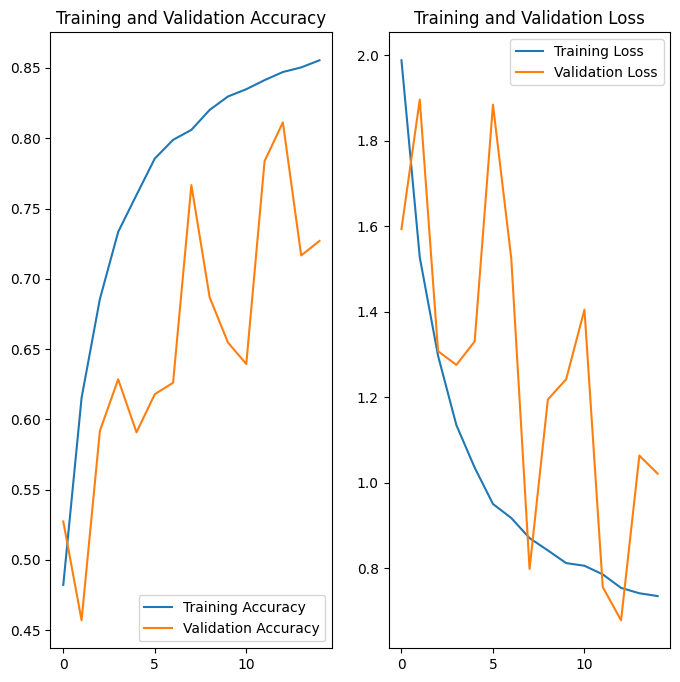

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()